<a href="https://colab.research.google.com/github/PatrykGluszekDS/TensorFlow-Projects-Showcase/blob/main/Time-Series/BikeSharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing

## Loading and exploring data

In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers

In [102]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bike-sharing-dataset' dataset.
Path to dataset files: /kaggle/input/bike-sharing-dataset


In [103]:
df = pd.read_csv(path + "/day.csv",
                 parse_dates=["dteday"],
                 index_col=["dteday"])
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 91.4 KB


In [105]:
# How many samples?
len(df)

731

In [106]:
counts = pd.DataFrame(df["cnt"])
counts.rename(columns={"cnt": "daily_total_rentals"}, inplace=True)
counts.head()

,daily_total_rentals
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


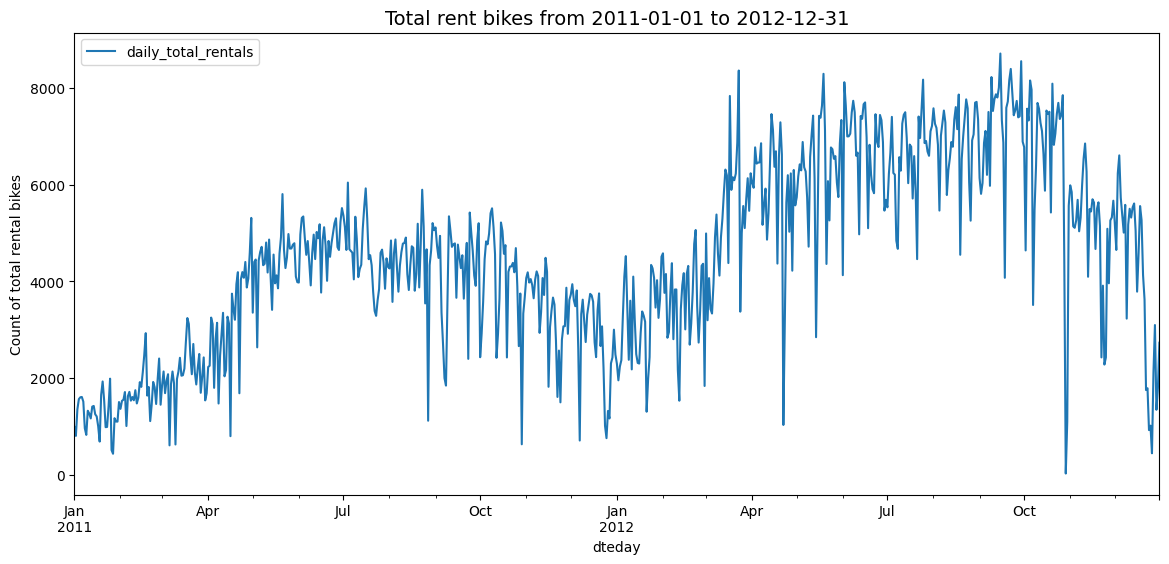

In [107]:
counts.plot(figsize=(14, 6))
plt.ylabel("Count of total rental bikes")
plt.title("Total rent bikes from 2011-01-01 to 2012-12-31", fontsize=14);

## Creating Train and Test splits

In [108]:
# Get counts date array
timesteps = counts.index.to_numpy()
numbers = counts["daily_total_rentals"].to_numpy()

timesteps[:10], numbers[:10]

(array(['2011-01-01T00:00:00.000000000', '2011-01-02T00:00:00.000000000',
        '2011-01-03T00:00:00.000000000', '2011-01-04T00:00:00.000000000',
        '2011-01-05T00:00:00.000000000', '2011-01-06T00:00:00.000000000',
        '2011-01-07T00:00:00.000000000', '2011-01-08T00:00:00.000000000',
        '2011-01-09T00:00:00.000000000', '2011-01-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([ 985,  801, 1349, 1562, 1600, 1606, 1510,  959,  822, 1321]))

In [109]:
# Create train and test splits for time series data
split_size = int(0.8 * len(numbers)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], numbers[:split_size]

# Create test data splits (everything beyond)
X_test, y_test = timesteps[split_size:], numbers[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(584, 584, 147, 147)

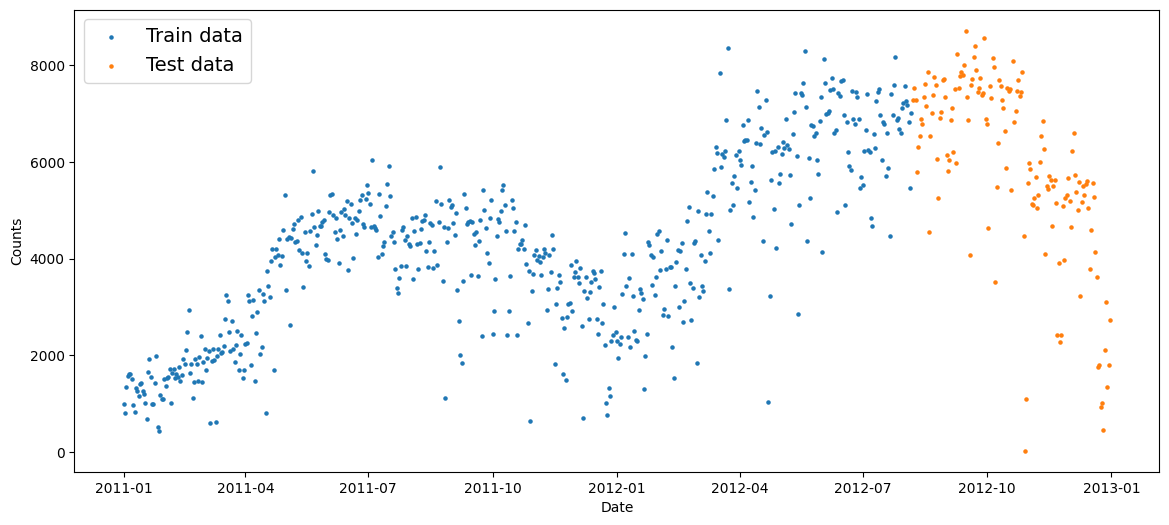

In [110]:
plt.figure(figsize=(14, 6))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.legend(fontsize=14)
plt.xlabel("Date")
plt.ylabel("Counts")
plt.show()

## Creating plotting function

In [111]:
# Create a function to plot time series data
def plot_time_series(timesteps,
                     values,
                     format='.',
                     start=0,
                     end=None,
                     label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Counts")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

## Modelling Experiments

0. Naive model (baseline)
1. Dense model, horizon=1, window=7
2. Same as model 1, horizon=1, window=30
3. Same as model 1, horizon=7, window=30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N-BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model

## Evaluation implementations

In [112]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """* Scaling by a non-seasonal benchmark"""
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [113]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Instantiate the metric class
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    rmse_metric = tf.keras.metrics.RootMeanSquaredError()

    # Update the object created with the values
    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)
    mape_metric.update_state(y_true, y_pred)
    rmse_metric.update_state(y_true, y_pred)

    # Evaluate the result and convert to numpy
    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    mape = mape_metric.result().numpy()
    rmse = rmse_metric.result().numpy()

    # Call our own function
    mase = mean_absolute_scaled_error(y_true, y_pred).numpy()

    # Return the dictionary object
    return {"mae": mae,
            "mse": mse,
            "rmse": rmse,
            "mape": mape,
            "mase": mase}

## Model 0: Naive forecast (baseline)

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [114]:
# Create a naive forecast
naive_forecast = y_test[:-1]

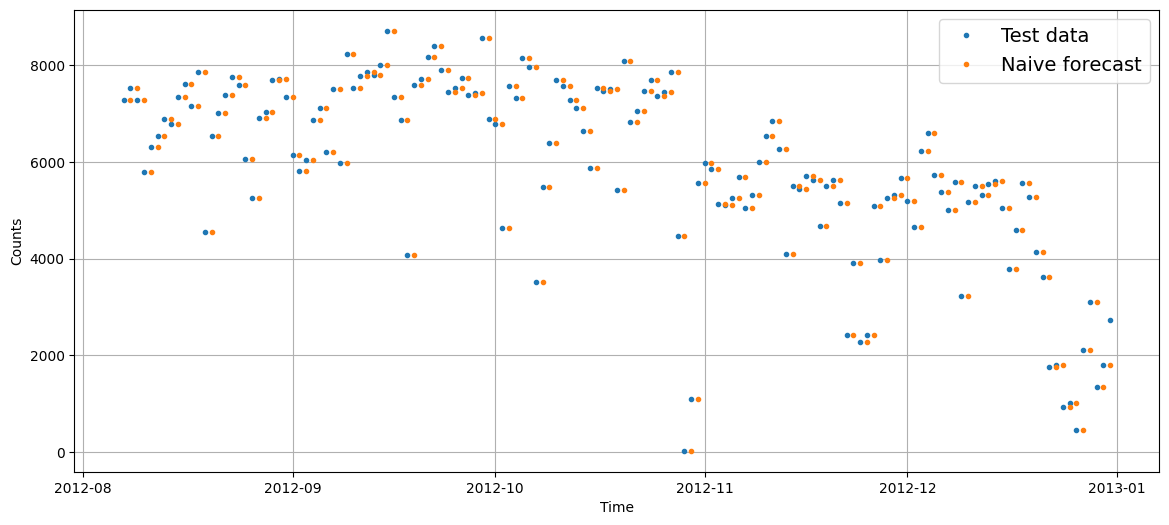

In [115]:
# Plot naive forecast
plt.figure(figsize=(14, 6))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label="Naive forecast")

In [116]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': np.float32(882.6301),
 'mse': np.float32(1655132.0),
 'rmse': np.float32(1286.5193),
 'mape': np.float32(158.03685),
 'mase': np.float32(0.9951663)}

## Windowing dataset

In [117]:
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of data to make the prediction

In [118]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([[0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [119]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [120]:
full_windows, full_labels = make_windows(numbers, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows.shape, full_labels.shape

((724, 7), (724, 1))

In [121]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [ 985  801 1349 1562 1600 1606 1510] -> Label: [959]
Window: [ 801 1349 1562 1600 1606 1510  959] -> Label: [822]
Window: [1349 1562 1600 1606 1510  959  822] -> Label: [1321]


### Turning windows into training and test sets

In [122]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [123]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(579, 145, 579, 145)

## Making modelling checkpoint

In [124]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

In [125]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_1_dense.keras")])

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 2209.1895 - mae: 2209.1895 - mse: 6364920.0000 - val_loss: 1786.1400 - val_mae: 1786.1400 - val_mse: 4022860.7500
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1057.0496 - mae: 1057.0496 - mse: 1707307.0000 - val_loss: 1077.7156 - val_mae: 1077.7156 - val_mse: 2579879.2500
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 815.2489 - mae: 815.2489 - mse: 1278088.3750 - val_loss: 1453.3097 - val_mae: 1453.3097 - val_mse: 3903446.5000
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 941.7847 - mae: 941.7847 - mse: 1631948.1250 - val_loss: 1086.3831 - val_mae: 1086.3831 - val_mse: 2639750.0000
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 744.7200 - mae: 744.7200 - mse: 1091513.2500 - val_loss: 998.3506 - val_mae: 998.3506 - val_mse: 2034068.2500
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 747.1541 - mae: 747.1541 - mse: 965177.8125 - val_loss: 998.9854 - val_mae: 998.9854 - va

In [126]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 722.9514 - mae: 722.9514 - mse: 1298529.1250


[797.955078125, 797.955078125, 1529309.375]

### Forecasts with a model

In [127]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [128]:
model_1_preds = make_preds(model_1, test_windows)

# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


{'mae': np.float32(797.95514),
 'mse': np.float32(1529309.6),
 'rmse': np.float32(1236.6526),
 'mape': np.float32(214.97028),
 'mase': np.float32(0.8952167)}

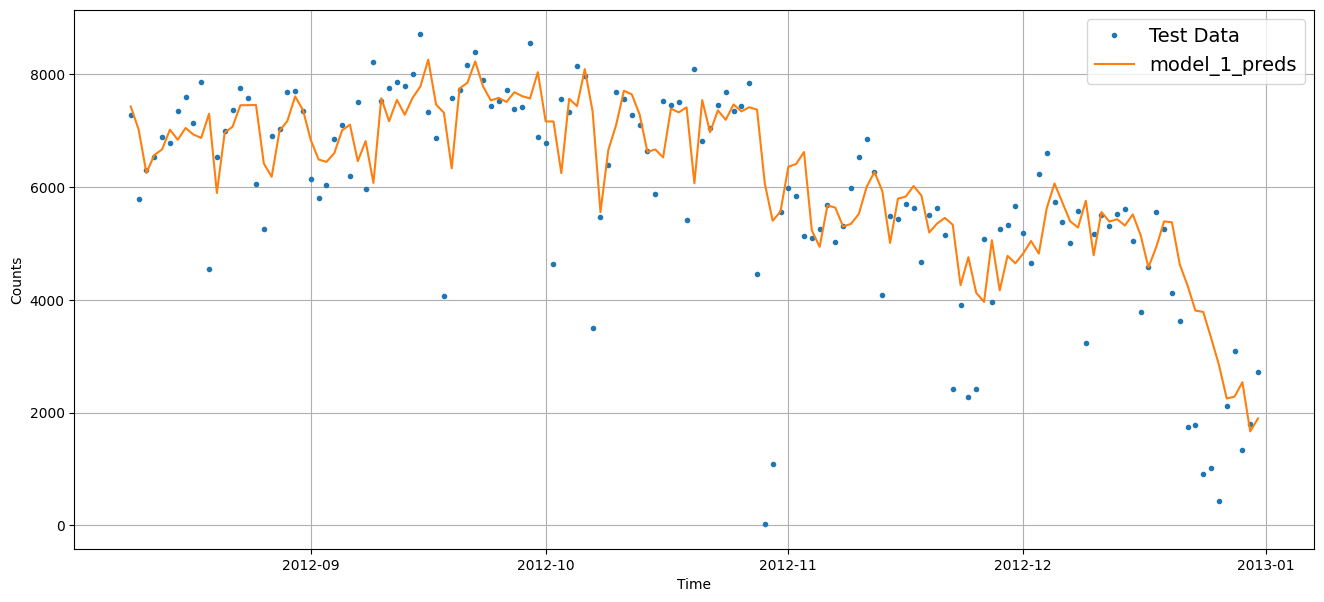

In [129]:
# Plot our model 1 predictions
plt.figure(figsize=(16,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [130]:
HORIZON = 1
WINDOW_SIZE = 30 # use 30 timesteps in past

In [131]:
full_windows, full_labels = make_windows(numbers, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows.shape, full_labels.shape

((701, 30), (701, 1))

In [132]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(560, 141)

In [133]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_2_dense.keras")])

In [134]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 770.0706


861.989013671875

In [135]:
model_2_preds = make_preds(model_2, test_windows)

# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


{'mae': np.float32(861.989),
 'mse': np.float32(1616672.9),
 'rmse': np.float32(1271.4845),
 'mape': np.float32(210.30757),
 'mase': np.float32(0.9596086)}

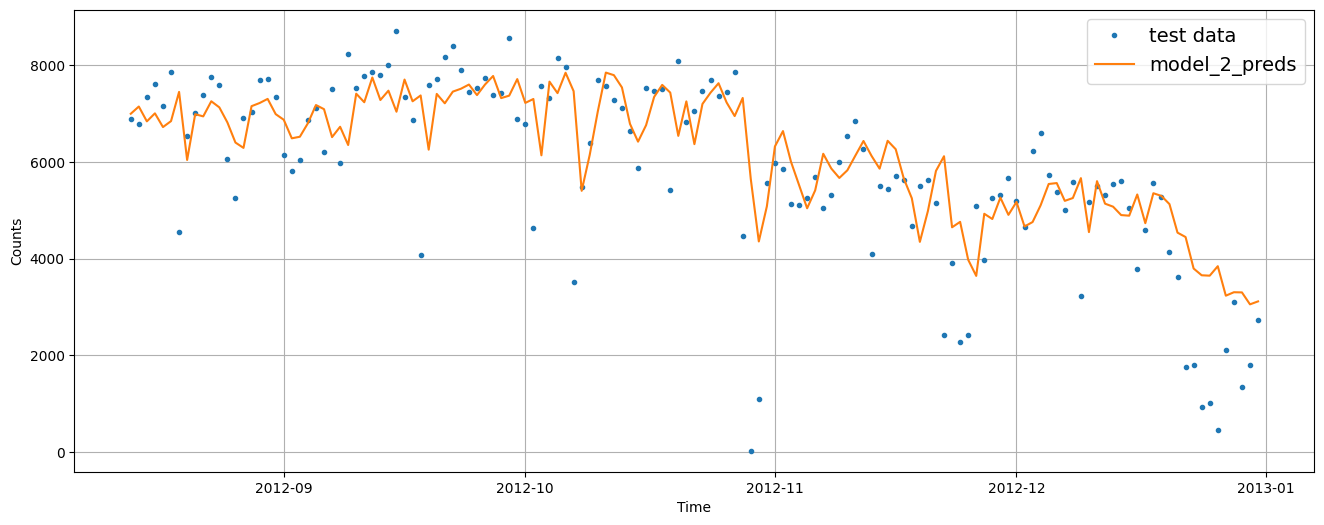

In [136]:
plt.figure(figsize=(16,6))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label="test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, format="-", label="model_2_preds")

##

## Model 3: Dense (window = 30, horizon = 7)

In [137]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(numbers, window_size=WINDOW_SIZE,
                                         horizon=HORIZON)
full_windows.shape, full_labels.shape

((695, 30), (695, 7))

In [138]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(556, 139, 556, 139)

In [139]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_3_dense.keras")])

In [140]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 875.4589


1014.468505859375

In [141]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


{'mae': np.float32(1014.4686),
 'mse': np.float32(2418026.0),
 'rmse': np.float32(1555.0004),
 'mape': np.float32(254.26428),
 'mase': np.float32(1.1363207)}

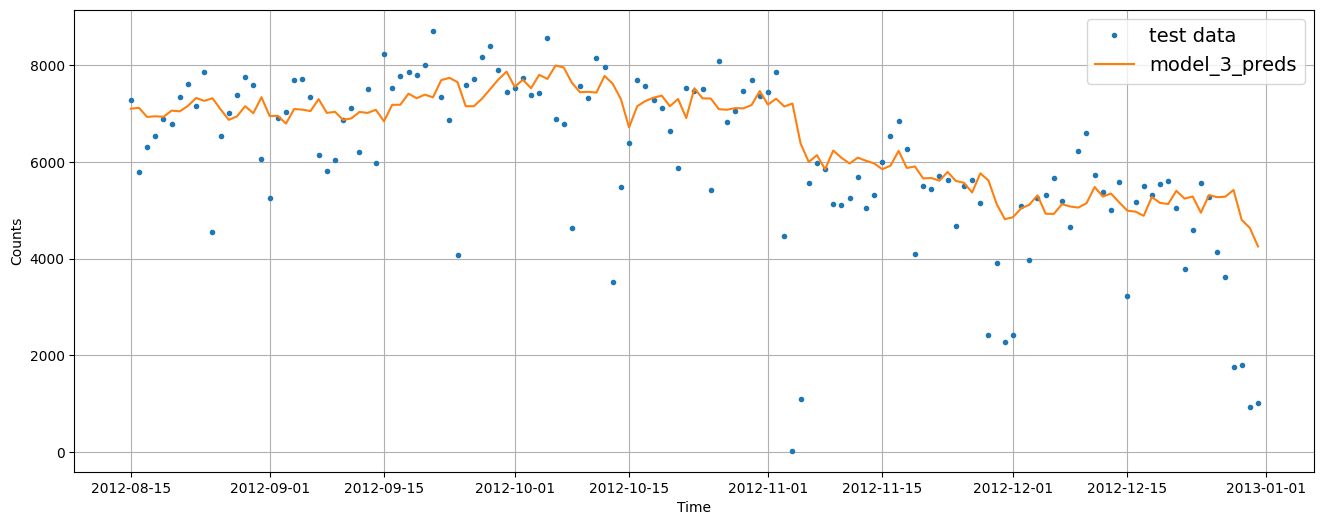

In [142]:
plt.figure(figsize=(16,6))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label="test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 label="model_3_preds")

## Model 4: Conv1D

In [143]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7

In [144]:
# Create windowed data
full_windows, full_labels = make_windows(numbers, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(724, 724)

In [145]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(579, 145, 579, 145)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`

In [146]:
def expd_dim(x):
    return tf.expand_dims(x, axis=-1)

In [147]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(expd_dim),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_4_conv1D.keras")])

In [148]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D.keras", custom_objects={"expd_dim": expd_dim})
model_4.evaluate(test_windows, test_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 845.6998


936.531494140625

In [149]:
model_4_preds = make_preds(model_4, test_windows)

# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


{'mae': np.float32(936.5315),
 'mse': np.float32(2022281.8),
 'rmse': np.float32(1422.0695),
 'mape': np.float32(261.46896),
 'mase': np.float32(1.0506839)}

## Model 5: RNN (LSTM)

In [150]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(expd_dim)(inputs)
x = layers.LSTM(128, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_5_LSTM.keras")])

In [151]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM.keras", custom_objects={"expd_dim": expd_dim})
model_5.evaluate(test_windows, test_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 751.7276


831.1107177734375

In [152]:
model_5_preds = make_preds(model_5, test_windows)

# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


{'mae': np.float32(831.1108),
 'mse': np.float32(1645610.1),
 'rmse': np.float32(1282.8134),
 'mape': np.float32(240.37947),
 'mase': np.float32(0.93241364)}

## Model 5.1: LSTM with tweaked hyperparameters

In [153]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(expd_dim)(inputs)
x = layers.LSTM(64, activation="tanh")(x)
outputs = layers.Dense(HORIZON)(x)
model_5_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_1_LSTM")

model_5_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5_1.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_5_1_LSTM.keras")])

In [154]:
# Load in best version of model 5_1 and evaluate on the test data
model_5_1 = tf.keras.models.load_model("model_experiments/model_5_1_LSTM.keras", custom_objects={"expd_dim": expd_dim})
model_5_1.evaluate(test_windows, test_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6423.4463 


5867.509765625

In [155]:
model_5_1_preds = make_preds(model_5_1, test_windows)

# Evaluate model 5 predictions
model_5_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_1_preds)
model_5_1_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


{'mae': np.float32(5867.51),
 'mse': np.float32(37958264.0),
 'rmse': np.float32(6161.028),
 'mape': np.float32(99.49502),
 'mase': np.float32(6.5826917)}

## Make a multivariate dataset

In [156]:
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [157]:
counts.head()

,daily_total_rentals
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [158]:
df_multi = df.copy()
counts_multi = df_multi[["cnt", "temp"]].rename(columns={"cnt": "daily_total_rentals"})
counts_multi.head()

,daily_total_rentals,temp
dteday,,
2011-01-01,985,0.344167
2011-01-02,801,0.363478
2011-01-03,1349,0.196364
2011-01-04,1562,0.200000
2011-01-05,1600,0.226957


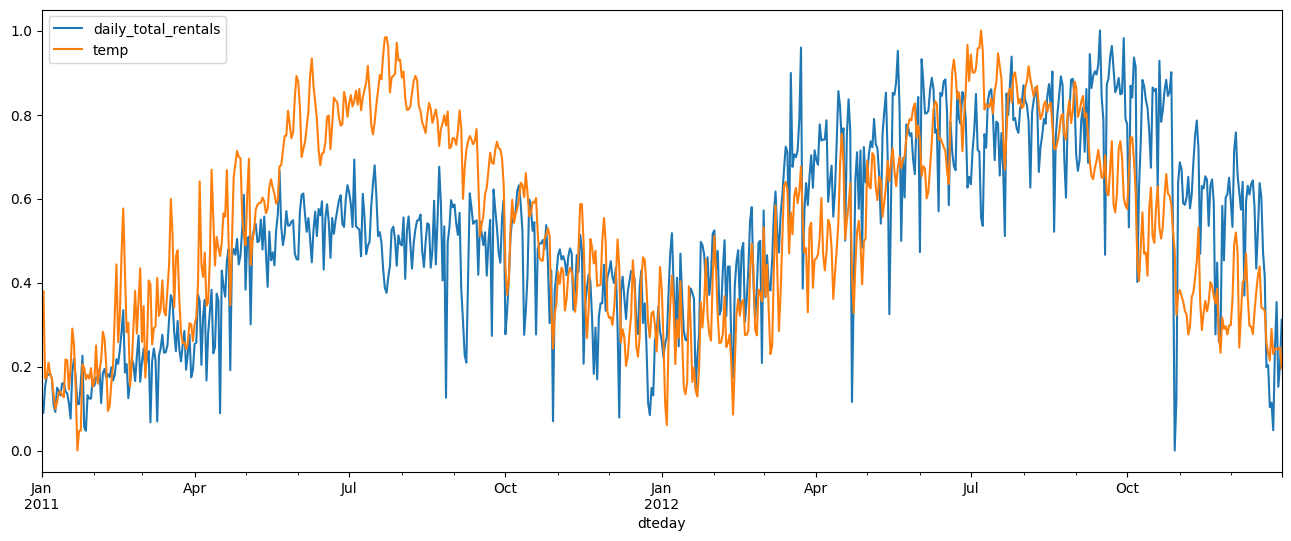

In [159]:
# Plot the temperature vs daily total rentals over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(counts_multi[["daily_total_rentals", "temp"]]),
                                     columns=counts_multi.columns,
                                     index=counts_multi.index)
scaled_price_block_df.plot(figsize=(16,6));

## Making windowed dataset with pandas

In [160]:
HORIZON = 1
WINDOW_SIZE = 7

In [161]:
# Make a copy of the data with temperature feature
counts_multi_windowed = counts_multi.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  counts_multi_windowed[f"daily_total_rentals+{i+1}"] = counts_multi_windowed["daily_total_rentals"].shift(periods=i+1)

In [162]:
counts_multi_windowed.head(10)

,daily_total_rentals,temp,daily_total_rentals+1,daily_total_rentals+2,daily_total_rentals+3,daily_total_rentals+4,daily_total_rentals+5,daily_total_rentals+6,daily_total_rentals+7
dteday,,,,,,,,,
2011-01-01,985,0.344167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,801,0.363478,985.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,1349,0.196364,801.0,985.0,NaN,NaN,NaN,NaN,NaN
2011-01-04,1562,0.200000,1349.0,801.0,985.0,NaN,NaN,NaN,NaN
2011-01-05,1600,0.226957,1562.0,1349.0,801.0,985.0,NaN,NaN,NaN
2011-01-06,1606,0.204348,1600.0,1562.0,1349.0,801.0,985.0,NaN,NaN
2011-01-07,1510,0.196522,1606.0,1600.0,1562.0,1349.0,801.0,985.0,NaN
2011-01-08,959,0.165000,1510.0,1606.0,1600.0,1562.0,1349.0,801.0,985.0
2011-01-09,822,0.138333,959.0,1510.0,1606.0,1600.0,1562.0,1349.0,801.0


In [163]:
# create X (windows) and y (horizons) features
X = counts_multi_windowed.dropna().drop("daily_total_rentals", axis=1).astype(np.float32)
y = counts_multi_windowed.dropna()["daily_total_rentals"].astype(np.float32)
X.head()

,temp,daily_total_rentals+1,daily_total_rentals+2,daily_total_rentals+3,daily_total_rentals+4,daily_total_rentals+5,daily_total_rentals+6,daily_total_rentals+7
dteday,,,,,,,,
2011-01-08,0.165000,1510.0,1606.0,1600.0,1562.0,1349.0,801.0,985.0
2011-01-09,0.138333,959.0,1510.0,1606.0,1600.0,1562.0,1349.0,801.0
2011-01-10,0.150833,822.0,959.0,1510.0,1606.0,1600.0,1562.0,1349.0
2011-01-11,0.169091,1321.0,822.0,959.0,1510.0,1606.0,1600.0,1562.0
2011-01-12,0.172727,1263.0,1321.0,822.0,959.0,1510.0,1606.0,1600.0


In [164]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(579, 579, 145, 145)

## Model 6: Dense (multivariate time series)

In [165]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name="model_6_dense_multivariate.keras")])

In [166]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 730.4492


804.8727416992188

In [167]:
model_6_preds = tf.squeeze(model_6.predict(X_test))

# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


{'mae': np.float32(804.87274),
 'mse': np.float32(1502384.8),
 'rmse': np.float32(1225.718),
 'mape': np.float32(220.6796),
 'mase': np.float32(0.90297747)}

## Model 7: N-BEATS algorithm

https://arxiv.org/pdf/1905.10437

### Building N-BEATS block layer

In [168]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments of tf.keras.layers.Layer
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons,
                                        activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### Preparing data for the N-BEATS algorithm using `tf.data`

In [169]:
HORIZON = 1
WINDOW_SIZE = 7

In [170]:
# Create NBEATS data inputs (N-BEATS works with univariate time series)
counts.head()

,daily_total_rentals
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [171]:
# Add winowed columns
counts_nbeats = counts.copy()
for i in range(WINDOW_SIZE):
  counts_nbeats[f"daily_total_rentals+{i+1}"] = counts_nbeats["daily_total_rentals"].shift(periods=i+1)
counts_nbeats.head()

,daily_total_rentals,daily_total_rentals+1,daily_total_rentals+2,daily_total_rentals+3,daily_total_rentals+4,daily_total_rentals+5,daily_total_rentals+6,daily_total_rentals+7
dteday,,,,,,,,
2011-01-01,985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,801,985.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,1349,801.0,985.0,NaN,NaN,NaN,NaN,NaN
2011-01-04,1562,1349.0,801.0,985.0,NaN,NaN,NaN,NaN
2011-01-05,1600,1562.0,1349.0,801.0,985.0,NaN,NaN,NaN


In [172]:
# Make features and labels
X = counts_nbeats.dropna().drop("daily_total_rentals", axis=1)
y = counts_nbeats.dropna()["daily_total_rentals"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(579, 579, 145, 145)

In [173]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Setting up hyperparameters

In [174]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Building, compiling and fitting the N-BEATS algorithm

In [175]:
tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_N-BEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 147: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 247: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [176]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 812.5975


812.5975341796875

In [177]:
# Make predictions wwith N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)

# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


{'mae': np.float32(812.5976),
 'mse': np.float32(1568402.9),
 'rmse': np.float32(1252.3589),
 'mape': np.float32(222.05801),
 'mase': np.float32(0.91164386)}

## Model 8: Creating an ensemble (stacking different models together)

In [178]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [179]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"])/
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(horizon)
          ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [180]:
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 203: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 303: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 268: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 368: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 201: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 166: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 266: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 156: ReduceLROnPl

### Make predictions with ensemble model

In [181]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [182]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


<tf.Tensor: shape=(15, 145), dtype=float32, numpy=
array([[7358.4424 , 7021.969  , 6163.549  , ..., 2721.0195 , 2202.4097 ,
        2723.6824 ],
       [6964.0156 , 7152.785  , 6406.702  , ..., 3991.484  , 1968.5575 ,
         922.393  ],
       [2530.8022 , 2120.5557 , 1367.0464 , ..., 1492.1359 , -475.80673,
        1805.6938 ],
       ...,
       [7185.497  , 7065.247  , 6588.7285 , ..., 2624.2258 , 1594.6478 ,
        2200.5571 ],
       [7145.4087 , 6823.6675 , 6158.843  , ..., 2195.4202 , 2214.22   ,
        2379.8228 ],
       [5830.5405 , 5994.4136 , 5248.305  , ..., 2730.4624 , 1868.0038 ,
        2285.801  ]], dtype=float32)>

In [183]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_median = np.median(ensemble_preds, axis=0)

ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': np.float32(848.9394),
 'mse': np.float32(1417041.0),
 'rmse': np.float32(1190.3953),
 'mape': np.float32(204.66617),
 'mase': np.float32(0.95241535)}

### Plotting the prediction intervals (uncertainty estimates) of ensemble

In [184]:
# Find upper and lower bound of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

In [185]:
# Get the upper amd lower bounds of thr 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

(<tf.Tensor: shape=(145,), dtype=float32, numpy=
 array([  424.65576  ,   893.19775  ,  -296.99023  ,   199.48291  ,
          132.49072  ,   332.43652  ,   639.6553   ,   443.60547  ,
          625.72363  ,   364.89258  ,   579.6636   ,  -100.26465  ,
          129.82812  ,   531.6011   ,    67.15088  ,  1323.9604   ,
          124.44238  ,   238.47314  ,   -65.91406  ,   271.2666   ,
          550.7417   ,   631.1001   ,  1061.251    ,    92.384766 ,
          195.71338  ,   -72.32422  ,   132.72021  ,   420.6294   ,
          664.39746  ,   192.87305  ,   535.3242   ,   130.46729  ,
          421.51318  ,   827.5303   ,   138.20264  ,   793.34766  ,
          -55.3291   ,   566.02734  ,   597.7363   ,   278.29443  ,
           63.934082 ,  -109.70557  ,   355.93994  ,   987.417    ,
          331.48096  ,  1649.7227   ,  -421.6255   ,   525.2832   ,
          145.44678  ,   212.66797  ,   330.53516  ,   331.78125  ,
          654.228    ,   299.36133  ,   121.811035 ,  -181.35986  ,

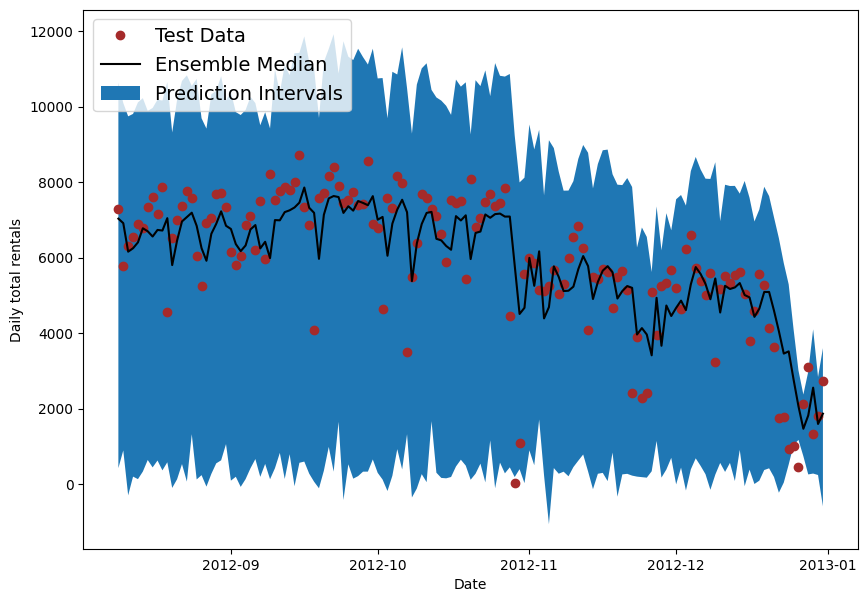

In [186]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
# offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index, y_test, "o", c="brown", label="Test Data")
plt.plot(X_test.index, ensemble_median, "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("Daily total rentals")
plt.fill_between(X_test.index,
                 (lower),
                 (upper), label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model 9: Train a model on the full historical data to make predictions into the future

In [187]:
HORIZON = 1
WINDOW_SIZE = 7

In [188]:
counts_multi_windowed.head()

,daily_total_rentals,temp,daily_total_rentals+1,daily_total_rentals+2,daily_total_rentals+3,daily_total_rentals+4,daily_total_rentals+5,daily_total_rentals+6,daily_total_rentals+7
dteday,,,,,,,,,
2011-01-01,985,0.344167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,801,0.363478,985.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,1349,0.196364,801.0,985.0,NaN,NaN,NaN,NaN,NaN
2011-01-04,1562,0.200000,1349.0,801.0,985.0,NaN,NaN,NaN,NaN
2011-01-05,1600,0.226957,1562.0,1349.0,801.0,985.0,NaN,NaN,NaN


In [189]:
# Train model on entire data to make predictions for the next day
X_all = counts_multi_windowed.dropna().drop(["daily_total_rentals", "temp"], axis=1).to_numpy()
# Get labels
y_all = counts_multi_windowed.dropna()["daily_total_rentals"].to_numpy()

len(X_all), len(y_all)

(724, 724)

In [190]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [191]:
tf.random.set_seed(42)

# Create model (simple)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions into future

In [192]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14

In [193]:
# Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  for _ in range(INTO_FUTURE):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

In [194]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicting on:
 [1013  441 2114 3095 1341 1796 2729] -> Prediction: 1861.7554931640625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Predicting on:
 [ 441.         2114.         3095.         1341.         1796.
 2729.         1861.75549316] -> Prediction: 2181.3447265625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting on:
 [2114.         3095.         1341.         1796.         2729.
 1861.75549316 2181.34472656] -> Prediction: 2369.926025390625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on:
 [3095.         1341.         1796.         2729.         1861.75549316
 2181.34472656 2369.92602539] -> Prediction: 2575.208251953125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicting on:
 [1341.         1796.         2729.         1861.75549316 2181.34472656
 2369.92602539 2575.20825195] -> Prediction: 1979.510498046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting on:
 [1796.         2729.         1861.75549316 2181.34472656 2369.92602539
 2575.208

In [195]:
future_forecast

[np.float32(1861.7555),
 np.float32(2181.3447),
 np.float32(2369.926),
 np.float32(2575.2083),
 np.float32(1979.5105),
 np.float32(2153.2874),
 np.float32(2427.6953),
 np.float32(2087.2058),
 np.float32(2279.5955),
 np.float32(2318.6384),
 np.float32(2395.277),
 np.float32(2183.221),
 np.float32(2236.4177),
 np.float32(2334.447)]

## Compare models

In [208]:
# Compare different model results (w=window, h=horizon)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results}).T

model_results

,mae,mse,rmse,mape,mase
naive_model,882.630127,1655132.000,1286.519287,158.036850,0.995166
model_1_dense_w7_h1,797.955139,1529309.625,1236.652588,214.970276,0.895217
model_2_dense_w30_h1,861.989014,1616672.875,1271.484497,210.307571,0.959609
model_3_dense_w30_h7,1014.468628,2418026.000,1555.000366,254.264282,1.136321
model_4_CONV1D,936.531494,2022281.750,1422.069458,261.468964,1.050684
model_5_LSTM,831.110779,1645610.125,1282.813354,240.379471,0.932414
model_6_multivariate,804.872742,1502384.750,1225.718018,220.679596,0.902977
model_7_NBEATS,812.597595,1568402.875,1252.358887,222.058014,0.911644
model_8_ensemble,848.939392,1417041.000,1190.395264,204.666168,0.952415


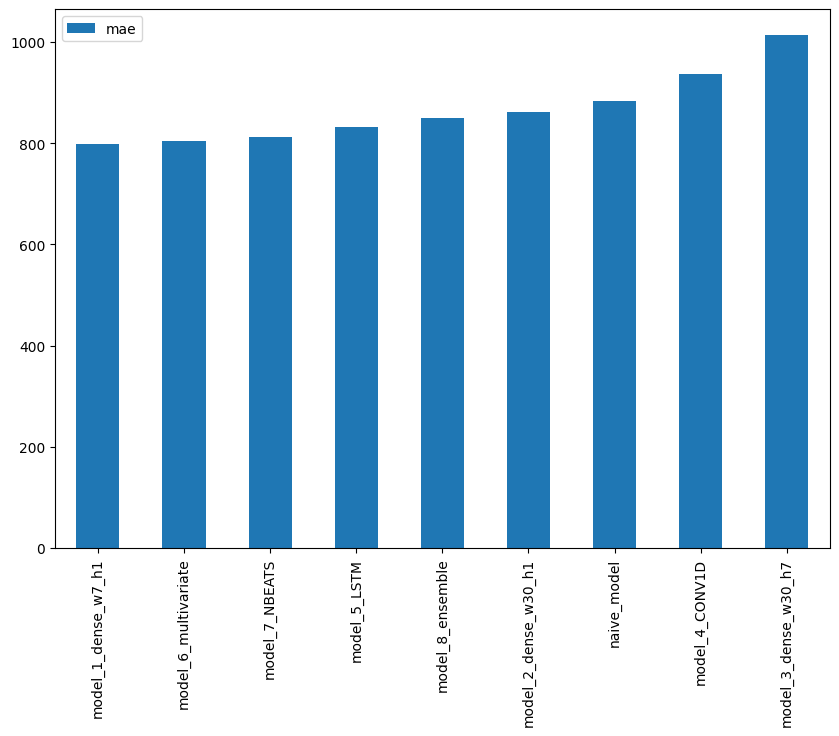

In [209]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");